In [1]:
import sys
import time

import matplotlib.pyplot as plt
import itertools as it
import tensorflow as tf
import multiprocessing as mp

tf.config.set_visible_devices([], "GPU")

print("Ok!")

2021-11-05 11:35:43.177134: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-05 11:35:43.177187: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Ok!


2021-11-05 11:35:45.004548: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-05 11:35:45.017169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-05 11:35:45.044113: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: UNKNOWN ERROR (100)
2021-11-05 11:35:45.044216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HUGO-SCHMEISSER): /proc/driver/nvidia/version does not exist


2021-11-05 11:35:50.765539: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


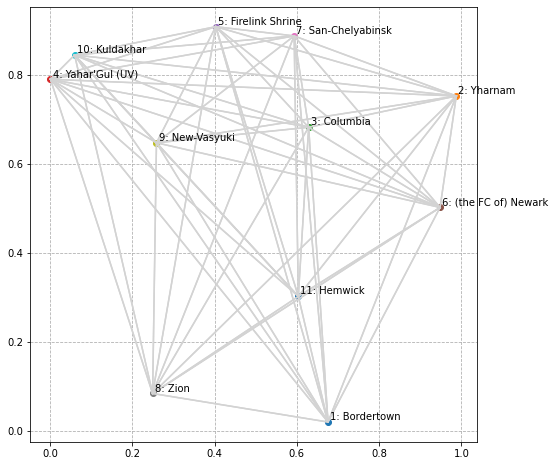

In [2]:
def generateTowns(n=10):
    townNames = ["Bordertown", "Yharnam", "Columbia", "Yahar'Gul (UV)", "Firelink Shrine",
                 "(the FC of) Newark", "San-Chelyabinsk", "Zion", "New-Vasyuki", "Kuldakhar",
                 "Hemwick", "Night-City", "Sliabh Luachra"]
    
    points = tf.random.stateless_uniform((n,2), seed=[4221, int(time.time())]).numpy().tolist()
    points = [tuple(i) for i in points]
    
    towns = [(no, name, coords) for no,name,coords in zip(range(1, n+1), townNames[:n], points)]
    return(towns)


def exclTown(towns, town):
    if not isinstance(town, list):
        town = [town]
    ## 
    return([t for t in towns if t not in town])


def plotTowns(towns, plotSize=8):
    '''
    towns: List[Tuple(no, name, Tuple(coordX, coordY))]
    '''
    fig, ax = plt.subplots(1,1, figsize=(plotSize, plotSize))
    for town in towns:
        otherTowns = exclTown(towns, town)
        for t in otherTowns:
            ax.plot([town[2][0], t[2][0]], [town[2][1], t[2][1]], c="lightgrey")
    for town in towns:       
        ax.scatter(town[2][0], town[2][1])
        ax.text(x=town[2][0]+0.005, y=town[2][1]+0.005, s="{}: {}".format(town[0],town[1]))
        
    ax.grid(ls="--")




towns = generateTowns(11)
plotTowns(towns)

In [ ]:
'''
task shall have a start point
travels are mirrored --> may count twice less
'''

def removeListItem(xs, x):
    return([i for i in xs if i!=x])


def prependBeginToEnds(begin, ends):
    '''
    begin: list[M]
    ends:  list[list[M]]
    '''
    if not isinstance(begin, list):
        begin = [begin]
    ##
    return([begin + e for e in ends])


def chainList(xs):
    '''
    xs: List[List[Any]]
    '''
    acc = []
    for x in xs:
        acc += x
    ##
    return(acc)


def flattenList(xs):
    if not isinstance(xs, list):
        xs = [xs]
        
    if all([not isinstance(x, list) for x in xs]):
        return(xs)
    else:
        acc = []
        for x in xs:
            if isinstance(x, list):
                acc += x
            else:
                acc += [x]
        return(flattenList(acc))


def combinations(xs):
    if len(xs) <= 1:
        return(xs)
    
    elif len(xs) == 2:
        return([xs, [xs[1], xs[0]]] )
    
    else:
        return(chainList(
                    [prependBeginToEnds([xs[i]], combinations(removeListItem(xs, xs[i]))) for i in range(len(xs))]
               ))
    
    
def listTravels(xs, x0):
    assert (x0 in xs), \
        "Start point shall be in a list in very beginning"
    
    xs = removeListItem(xs, x0)
    
    combs = combinations(xs)
    
    combs = [[x0] + xi + [x0] for xi in combs]
    
    ##
    return(combs)
    

'''
xs = list(range(1,5))
print(xs)
print()

listTravels(xs, 3)
'''
print("Nothing to see here")

In [ ]:
'''
startName = "Bordertown"
startTown = [t for t in towns if t[1]==startName][0]

travels = listTravels(towns, startTown)
travels
'''

print("Nothing happens here how")

In [ ]:
def tfRoll(xs, value):
    xs = tf.convert_to_tensor(xs)
    return(tf.concat([xs[..., value:], xs[..., :value]], axis=-1))


def tfCoordDiffs(coords):
    coords = tf.convert_to_tensor(coords)
    return(tf.stack([coords[..., rv] - coords for rv in range(coords.shape[-1])], axis=0))


def tfDists(xs, ys):
    xsDiffs = tfCoordDiffs(xs)
    ysDiffs = tfCoordDiffs(ys)
    
    ##
    return(tf.math.sqrt(tf.square(xsDiffs) + tf.square(ysDiffs)))


'''
##  ##
xs = [t[2][0] for t in towns]
ys = [t[2][1] for t in towns]
print(xs)
print(ys)

tfDists(xs, ys)
'''
print("Nothing to see here")

In [ ]:
'''
def findWay(towns, startName, verbose=False, debug=False):
    xs = [t[2][0] for t in towns]
    ys = [t[2][1] for t in towns]
    
    dists = tfDists(xs, ys)
    
    startTown = [t for t in towns if t[1]==startName][0]
    travels = listTravels(towns, startTown)
    
    numTravels = len(travels)
    
    countedTravels = []
    for no, travel in enumerate(travels):
        distPassed = 0
        for passi in range(len(travel) - 1):
            noStart = travel[passi][0] - 1
            noFinish = travel[passi+1][0] - 1
            distPassed += dists[noStart, noFinish]
                
        countedTravels += [(travel, distPassed.numpy())]
        
        if verbose:
            print("Humble report. Counted {} / {}".format(no, numTravels), end="\r")
    
    if verbose:
        print()
        
    shortestTravelDist = countedTravels[0][1]
    for t in countedTravels[1:]:
        if t[1] < shortestTravelDist:
            shortestTravelDist = t[1]
            
    shortestTravels = [t for t in countedTravels if t[1]==shortestTravelDist]
        
    ##
    if debug:
        return(shortestTravels, countedTravels, dists)
    else:
        return(shortestTravels)

    
##  ##
timeStart = time.time()
shortest, allTravels, dists = findWay(towns, "Bordertown", True)

timeTaken = time.time() - timeStart
print("Ok! Time taken: {} sec.".format("%.2f"%timeTaken))
'''
print("Nothing happens here anymore")

In [ ]:
def batchList(xs, batchSize=None, numBatches=None):
    '''
    only python used

    ARGUMENTS:
    xs: List[Any] - list of something
    batchSize: Integer
    numBatches: Integer

    RETURNS:
    List[List[Any]]
    '''
    count = len(xs)
    
    ##
    if (batchSize is not None) and (numBatches is None):
        numBatches = count // batchSize + int(count % batchSize != 0)
        
        slices = [slice(i*batchSize, (i+1)*batchSize, 1) for i in range(numBatches)]
        batches = [xs[slicei] for slicei in slices]
        
    ##
    elif (batchSize is None) and (numBatches is not None):
        minBatchSize = count // numBatches 
        
        adds = [1]*(count - minBatchSize*numBatches) + [0]*(numBatches - (count - minBatchSize*numBatches))
        batchSizes = [minBatchSize + a for a in adds]
        cumBatchSizes = [sum(batchSizes[:i]) for i in range(len(batchSizes)+1)]
        
        slices = [slice(start, stop, 1) for start, stop in zip(cumBatchSizes[:-1], cumBatchSizes[1:])]
        
        batches = [xs[slicei] for slicei in slices]
        batches = [b for b in batches if b]        
        
    ##
    else:
        raise Exception("Either 'batchSize' or 'numBatches' argument shall be defined")

    ##
    return(batches)


def countTravel(distances, name=None):
    def underhood(travel):
        distPassed = 0
        for passi in range(len(travel) - 1):
            noStart = travel[passi][0] - 1
            noFinish = travel[passi+1][0] - 1
            distPassed += distances[noStart, noFinish]    

        ##
        return((travel, distPassed))
    
    ##
    if name is not None:
        underhood.__name__ = name
    return(underhood)


def countTravelWorkerFn(distances, queOut, name=None):
    countTravelFn = countTravel(distances)
    
    def underhood(travels):
        countTravels = []
        for t in travels:
            countTravels += [countTravelFn(t)]
            
        queOut.put(countTravels)
            
        ##
        return(None)
    
    ##
    if name is not None:
        underhood.__name__ = name
    return(underhood)   


def findWayPar(towns, startName=None, numWorkers=None, verbose=False, debug=False):
    xs = [t[2][0] for t in towns]
    ys = [t[2][1] for t in towns]
    
    dists = tfDists(xs, ys)
    
    if startName is not None:
        startTown = [t for t in towns if t[1]==startName][0]
    else:
        startTown = towns[0]
    travels = listTravels(towns, startTown)
    
    numTravels = len(travels)
    numWorkers = max(1, mp.cpu_count()-2)
    travelBatches = batchList(travels, numBatches=numWorkers)
    
    ##
    ques = [mp.Queue() for _ in range(numWorkers)]
    workers = [mp.Process(target=countTravelWorkerFn(distances=dists, queOut=que),
                          kwargs={"travels": ti}) \
               for que, ti in zip(ques, travelBatches)]
    
    for worker in workers:
        worker.start()
    print("Humble report: Workers started")
        
    countedTravels = [que.get() for que in ques]
    countedTravels = list(it.chain.from_iterable(countedTravels))
    print("Humble report: Results collected")
    
    for worker in workers:
        worker.join()
    ret = all([not worker.is_alive() for worker in workers])
    print("Humble report: All workers stopped: {}".format(ret))
    ##
        
    shortestTravelDist = countedTravels[0][1]
    for t in countedTravels[1:]:
        if t[1] < shortestTravelDist:
            shortestTravelDist = t[1]
            
    shortestTravels = [t for t in countedTravels if t[1]==shortestTravelDist]
        
    ##
    if debug:
        return(shortestTravels, countedTravels, dists)
    else:
        return(shortestTravels)




##  ##
timeStart = time.time()
shortest, counted, dists = findWayPar(towns, debug=True)

timeTaken = time.time() - timeStart
print("Ok! Time taken: {} sec.".format("%.2f"%timeTaken))

In [ ]:
'''
n=10 == single thread == Ok! Time taken: 369.90 sec.
n=10 == 14 threads == Ok! Time taken: 53.66 sec.
n=11 == 14 threads == Ok! Time taken: 600.58 sec.
'''

def plotTownsEx(towns, shortestTravel=None, plotSize=10):
    '''
    towns: List[Tuple(no, name, Tuple(coordX, coordY))]
    '''
    fig, ax = plt.subplots(1,1, figsize=(plotSize, plotSize))
    for town in towns:
        otherTowns = exclTown(towns, town)
        for t in otherTowns:
            ax.plot([town[2][0], t[2][0]], [town[2][1], t[2][1]], c="lightgrey")
    for town in towns:       
        ax.scatter(town[2][0], town[2][1])
        ax.text(x=town[2][0]+0.005, y=town[2][1]+0.005, s="{}: {}".format(town[0],town[1]))
        
    if shortestTravel is not None:
        travel = shortestTravel[0]
        short = shortestTravel[1]
        shortXs = [t[2][0] for t in travel]
        shortYs = [t[2][1] for t in travel]
        
        ax.plot(shortXs, shortYs, c="red")
        
    ax.grid(ls="--")



plotTownsEx(towns, shortest[0])